## [Tensorflow in Practice] Course 1, 2 - 요약


---


### (point 1) 샘플데이터 로딩

*   tf.keras.datasets로 가져오기
*   wget으로 가져오기 (경로지정 & ImageDataGenerator사용)

### (point 2) 모델링

*   Dense, Flatten
*   CNN, Dropout, Maxpooling

### (point 3) Data Augmentation

*   ImageDataGenerator사용

### (point 4) Transfer Learning
*   가져와서 프리징시키기
*   모델 뒷단에 더 이어 붙이기
---
### (point 5) history 시각화

### (point 6) model.fit의 파라미터의 의미
*   verbose
*   validation_steps
*   steps_per_epoch


### (point 7) 콜백함수 사용법




## 1. 완전 기본 예제

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])

model.compile(optimizer='sgd', loss='mean_squared_error')

xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

model.fit(xs, ys, epochs=50, verbose=1) # verbose mode 설정 (실행 경과를 보는?) : 0 = silent, 1 = progress bar, 2 = one line per epoch. 기본값은 1

print(model.predict([10.0]))

## 2. MNIST / Dense / Callback

In [ ]:
import tensorflow as tf

# data load : Fashion MNIST
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# preprocess
x_train, x_test = x_train / 255.0, x_test / 255.0

# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.6):
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# modeling
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input_shape 안써줘도 됨.
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer='adam'',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# fit
model.fit(x_train, y_train, epochs=10, callbacks=[callbacks])

# evaluate
test_loss = model.evaluate(x_test, y_test)

## 3. MNIST / CNN

In [ ]:
import tensorflow as tf
print(tf.__version__)

# data load : Fashion MNIST
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# preprocess

# CNN쓸때는 reshape를 해줘야됨.
# reshape해야되는 이유 : first convolution expects a single tensor containing everything, 
# before : (60000, 28, 28) - 60,000 28x28x1 items in a list
# after  : (60000, 28, 28, 1) - a single 4D list that is 60,000x28x28x1
training_images=training_images.reshape(60000, 28, 28, 1) 
test_images = test_images.reshape(10000, 28, 28, 1)
training_images=training_images / 255.0
test_images=test_images/255.0

# modeling
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# fit
model.fit(training_images, training_labels, epochs=5)

# evaluate
test_loss = model.evaluate(test_images, test_labels)

## 4. human_horse / CNN / ImageDataGenerator

In [ ]:
# data download
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip


# unzip
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')

local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')

zip_ref.close()

# directory : 디렉토리 경로지정 => ImageDataGenerator에서 이 경로에 접근해서 레이블링하면서 데이터 읽는다.
train_dir = '/tmp/horse-or-human/'
validation_dir = '/tmp/validation-horse-or-human/'


# ImageDataGenerator 선언
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# 지정한 경로의 이미지들을 배치로 묶으면서, resize하고 속한 폴더명으로 라벨링까지.
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  
        target_size=(150, 150), 
        batch_size=32,
        class_mode='binary')

# modeling
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

# compile
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

# fit
history = model.fit(train_generator,
                    steps_per_epoch=8,  # 한 에포크에 몇개의 배치를 학습에 이용할건지. 기본값은 전체 배치를 다 이용함(전체데이터/배치사이즈)
                    epochs=15,
                    verbose=1,
                    validation_data = validation_generator,
                    validation_steps=8 # validation에 사용할 배치샘플 개수)

## 5. cat_dog / CNN / ImageDataGenerator (Data Augmentation)

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# data download
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  


# unzip
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# 디렉토리 경로 지정
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# ImageDataGenerator 선언 

# 학습 Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# 지정한 경로의 이미지들을 배치로 묶으면서, resize하고 속한 폴더명으로 라벨링까지.
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=20,
        class_mode='binary') # 레이블이 3개 이상이면 'categorical'

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# modeling
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

## 6. history 시각화

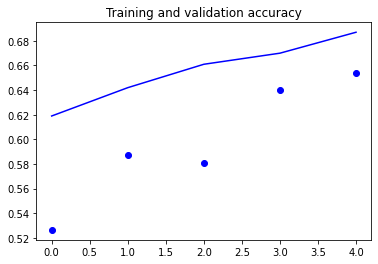

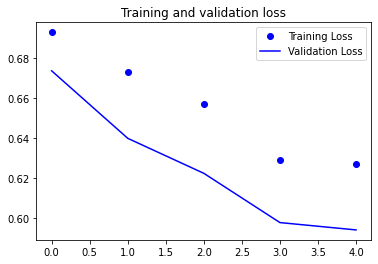

In [31]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 7. Transfer Learning (inception_v3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

# data download
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

# unzip
local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# 디렉토리 경로 지정
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

import os
from tensorflow.keras import layers
from tensorflow.keras import Model

### get pretrained model's weight
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

### get pretrained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

## Freezing
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

### modeling
from tensorflow.keras.optimizers import RMSprop
x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense  (1, activation='sigmoid')(x) # Add a final sigmoid layer for classification       

# set model input & output
model = Model( pre_trained_model.input, x) 

# compile
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

# fit
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 10,
            validation_steps = 50,
            verbose = 2)